Chaining: API
=============

Non-linear search chaining is an advanced model-fitting approach in **PyAutoLens** which breaks the model-fitting
procedure down into multiple non-linear searches, using the results of the initial searches to initialization parameter
sampling in subsequent searches. This contrasts the `modeling` examples which each compose and fit a single lens
model-fit using one non-linear search.

The benefits of non-linear search chaining are:

 - Earlier searches fit simpler lens models than the later searches, which have a less complex non-linear parameter
 space that can be sampled more efficiently, with a reduced chance of inferring an incorrect local maxima solution.

 - Earlier searches can use faster non-linear search settings which infer the highest log likelihood models but not
 precisely quantify the parameter errors, with only the final searches using slow settings to robustly estimate errors.

 - Earlier searches can augment the data or alter the fitting-procedure in ways that speed up the computational run
 time. These may impact the quality of the model-fit overall, but they can be reverted to the more accurate but more
 computationally expense setting in the final searches.

This script gives an overview of the API for search chaining, a description of how the priors on parameters are used
to pass information between searches as well as tools for customizing prior passing. The examples in the 
`chaining/examples` show specific examples where for lens modeling search chaining can improve the model-fit.

More details on prior chaining can be found in Chapter 3 of the HowToLens lectures.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

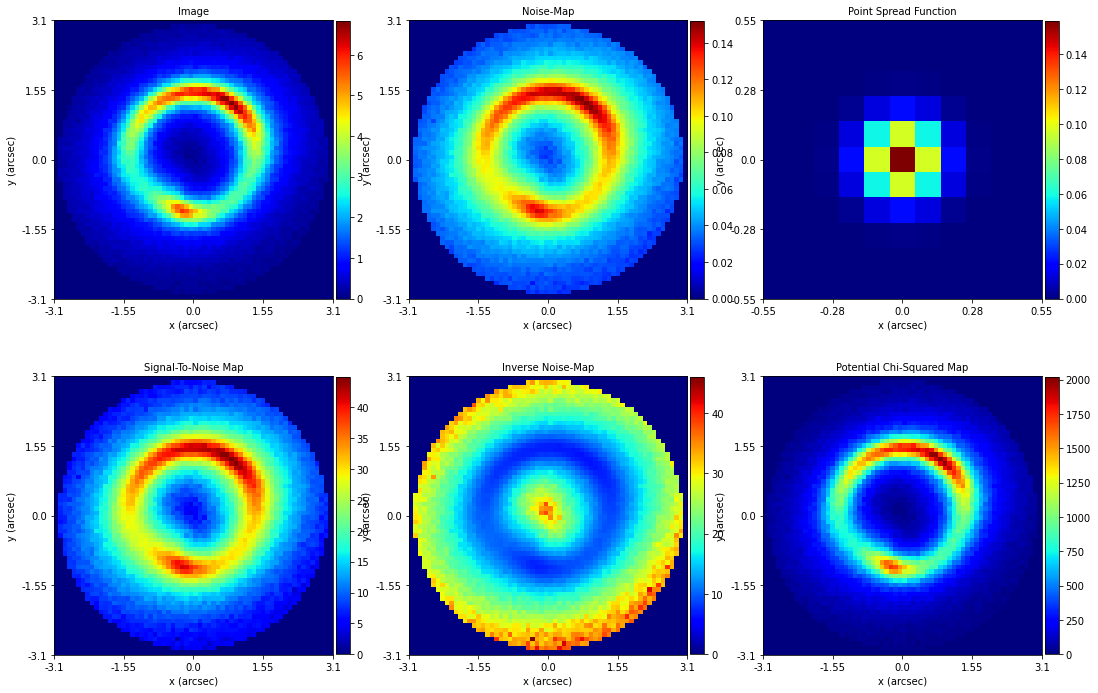

In [2]:
dataset_name = "mass_power_law__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "chaining", "api")

__Model (Search 1)__

We compose our lens model using `Model` objects, which represent the galaxies we fit to our data. In the first
search our lens model is:

 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 - An `EllSersic` `LightProfile` for the source galaxy's light [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

In [4]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))
# %%
'''
__Search + Analysis + Model-Fit (Search 1)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.
'''

'\n__Search + Analysis + Model-Fit (Search 1)__\n\nWe now create the non-linear search, analysis and perform the model-fit using this model.\n\nYou may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that \nprovides a reasonably accurate lens model.\n'

In [5]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]__api", n_live_points=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.44it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model Chaining__

We use the results of search 1 to create the `Model` components that we fit in search 2.

The term `model` below passes the lens and source models as model-components that are to be fitted
for by the non-linear search. In other chaining examples, we'll see other ways to pass prior results.

In [6]:
lens = result_1.model.galaxies.lens
source = result_1.model.galaxies.source

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search + Analysis + Model-Fit (Search 2)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the `model.info` file of the search 2 model-fit to ensure the priors were passed correctly, as 
well as the checkout the results to ensure an accurate power-law mass model is inferred.

In [7]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[2]__api", n_live_points=30
)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 174.91it/s, +30 | bound: 0 | nc: 1 | ncall: 32 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.039]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


We will expand on this API in the following tutorials. The main thing to note is that we can pass entire profiles or
galaxies using prior passing, if their model does not change (which for the bulge, mass and source_bulge above, was not
true). The API to pass a whole profile or galaxy is as follows:
 
 bulge = result_1.model.galaxies.lens.bulge
 lens = result_1.model.galaxies.lens
 source = result_1.model.galaxies.source
 
We can also pass priors using an `instance` instead of a `model`. When an `instance` is used, the maximum likelihood
parameter values are passed as fixed values that are therefore not fitted for nby the non-linear search (reducing its
dimensionality). We will use this in the next tutorial to fit the lens light, fix it to the best-fit model in a second
search, and then go on to fit it as a model in the final search.
 
Lets now thinking about how priors are passed. Checkout the `model.info` file of the second search of this tutorial. 
The parameters do not use the default  priors we saw in search 1 (which are typically broad UniformPriors). Instead, 
they use GaussianPrior`s where:

 - The mean values are the median PDF results of every parameter in search 1.
 - Many sigma values are the errors computed at 3.0 sigma confidence of every parameter in search 1.
 - Other sigma values are higher than the errors computed at 3.0 sigma confidence. These instead use the value 
 specified in the `width_modifier` field of the `Profile`'s entry in the `json_config` files (we will discuss
 why this is used in a moment).

Thus, much like the manual GaussianPriors I specified above, we have set up the search with GaussianPriors centred on
the high likelihood regions of parameter space!
 
The priors passed above retained the model parameterization of search 1, including the fixed values of (0.0, 0.0) for
the centres of the light and mass profiles and the alignment between their elliptical components. However, we often 
want to pass priors *and* change the model parameterization.

In [8]:

# %%
'''
__Detailed Explanation Of Prior Passing__

To end, I provide a detailed overview of how prior passing works and illustrate tools that can be used to customize
its behaviour. It is up to you whether you want read this, or go ahead to the next tutorial!

Lets say I chain two parameters as follows:
 
 ```
 mass.einstein_radius = result_1.model.galaxies.lens.mass.einstein_radius
```

By invoking the `model` attribute, the priori s passed following 3 rules:

 1) The new parameter, in this case the einstein radius, uses a GaussianPrior. A GaussianPrior is ideal, as the 1D 
 pdf results we compute at the end of a search are easily summarized as a Gaussian.

 2) The mean of the GaussianPrior is the median PDF value of the parameter estimated in search 1.
    
 This ensures that the initial sampling of the new search's non-linear starts by searching the region of non-linear 
 parameter space that correspond to highest log likelihood solutions in the previous search. Thus, we're setting 
 our priors to look in the `correct` regions of parameter space.

 3) The sigma of the Gaussian will use the maximum of two values: 
   
 (i) the 1D error of the parameter computed at an input sigma value (default sigma=3.0).
 
 (ii) The value specified for the profile in the `config/priors/*.json` config file's `width_modifer` 
 field (check these files out now).

 The idea here is simple. We want a value of sigma that gives a GaussianPrior wide enough to search a broad 
 region of parameter space, so that the lens model can change if a better solution is nearby. However, we want it 
 to be narrow enough that we don't search too much of parameter space, as this will be slow or risk leading us 
 into an incorrect solution! A natural choice is the errors of the parameter from the previous search.
       
 Unfortunately, this doesn't always work. Lens modeling is prone to an effect called `over-fitting` where we 
 underestimate the errors on our lens model parameters. This is especially true when we take the shortcuts in 
 early searches - fast non-linear search settings, simplified lens models, etc.
    
 Therefore, the `width_modifier` in the json config files are our fallback. If the error on a parameter is 
 suspiciously small, we instead use the value specified in the widths file. These values are chosen based on 
 our experience as being a good balance broadly sampling parameter space but not being so narrow important solutions 
 are missed. 
       
There are two ways a value is specified using the priors/width file:

 1) Absolute: In this case, the error assumed on the parameter is the value given in the config file. 
 For example, if for the width on centre_0 of a `LightProfile`, the width modifier reads "Absolute" with a value 
 0.05. This means if the error on the parameter centre_0 was less than 0.05 in the previous search, the sigma of 
 its GaussianPrior in this search will be 0.05.
    
 2) Relative: In this case, the error assumed on the parameter is the % of the value of the 
 estimate value given in the config file. For example, if the intensity estimated in the previous search was 2.0, 
 and the relative error in the config file reads "Relative" with a value 0.5, then the sigma of the GaussianPrior 
 will be 50% of this value, i.e. sigma = 0.5 * 2.0 = 1.0.

We use absolute and relative values for different parameters, depending on their properties. For example, using the 
relative value of a parameter like the `Profile` centre makes no sense. If our lens galaxy is centred at (0.0, 0.0), 
the relative error will always be tiny and thus poorly defined. Therefore, the default configs in **PyAutoLens** use 
absolute errors on the centre.

However, there are parameters where using an absolute value does not make sense. Intensity is a good example of this. 
The intensity of an image depends on its unit_label, S/N, galaxy brightness, etc. There is no single absolute value 
that one can use to generically chain the intensity of any two proflies. Thus, it makes more sense to chain them using 
the relative value from a previous search.

We can customize how priors are passed from the results of a search and non-linear search by inputting to the search 
a PriorPasser object:

'''

'\n__Detailed Explanation Of Prior Passing__\n\nTo end, I provide a detailed overview of how prior passing works and illustrate tools that can be used to customize\nits behaviour. It is up to you whether you want read this, or go ahead to the next tutorial!\n\nLets say I chain two parameters as follows:\n \n ```\n mass.einstein_radius = result_1.model.galaxies.lens.mass.einstein_radius\n```\n\nBy invoking the `model` attribute, the priori s passed following 3 rules:\n\n 1) The new parameter, in this case the einstein radius, uses a GaussianPrior. A GaussianPrior is ideal, as the 1D \n pdf results we compute at the end of a search are easily summarized as a Gaussian.\n\n 2) The mean of the GaussianPrior is the median PDF value of the parameter estimated in search 1.\n    \n This ensures that the initial sampling of the new search\'s non-linear starts by searching the region of non-linear \n parameter space that correspond to highest log likelihood solutions in the previous search. Thus,

In [9]:
search = af.DynestyStatic(
    prior_passer=af.PriorPasser(sigma=2.0, use_widths=False, use_errors=True)
)

The PriorPasser allows us to customize at what sigma the error values the model results are computed at to compute
the passed sigma values and customizes whether the widths in the config file, these computed errors, or both, 
are used to set the sigma values of the passed priors.

The default values of the PriorPasser are found in the config file of every non-linear search, in the [prior_passer]
section. All non-linear searches by default use a sigma value of 3.0, use_width=True and use_errors=True. We anticipate
you should not need to change these values to get lens modeling to work proficiently!

__EXAMPLE__

Lets go through an example using a real parameter. Lets say in search 1 we fit the lens galaxy's light with an 
elliptical Sersic profile, and we estimate that its sersic index is equal to 4.0 ± 2.0 where the error value of 2.0 
was computed at 3.0 sigma confidence. To pass this as a prior to search 2, we would write:

 lens.bulge.sersic_index = result_1.model.lens.bulge.sersic_index

The prior on the lens galaxy's sersic `LightProfile` in search 2 would thus be a GaussianPrior, with mean=4.0 and 
sigma=2.0. If we had used a sigma value of 1.0 to compute the error, which reduced the estimate from 4.0 ± 2.0 to 
4.0 ± 1.0, the sigma of the Gaussian prior would instead be 1.0. 

If the error on the Sersic index in search 1 had been really small, lets say, 0.01, we would instead use the value of the 
Sersic index width in the priors config file to set sigma instead. In this case, the prior config file specifies 
that we use an "Absolute" value of 0.8 to chain this prior. Thus, the GaussianPrior in search 2 would have a mean=4.0 and 
sigma=0.8.

If the prior config file had specified that we use an relative value of 0.8, the GaussianPrior in search 2 would have a 
mean=4.0 and sigma=3.2.

And with that, we're done. Chaining priors is a bit of an art form, but one that tends to work really well. Its true to 
say that things can go wrong - maybe we `trim` out the solution we're looking for, or underestimate our errors a bit 
due to making our priors too narrow. However, in general, things are okay, and the example pipelines in 
`autolens_workspace/pipelines` have been thoroughly tested to ensure prior chaining works effectively.